In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pymc3 as pm
import theano

In [15]:
with open('fits/men_nonmulti_elts.pickle') as f:
    (traces, models, skater_shored) = pickle.load(f)

In [16]:
with open('fits/men_nonmulti_comps.pickle') as f:
    (_, pooled_models, _, unpooled_models, _) = pickle.load(f)

In [21]:
unpooled_models['tr']

In [2]:
with open('seasons.pickle') as f:
    seasons = pickle.load(f)
for year, season in seasons.iteritems():
    print year,
    season.load_scores()

with open('season2018.pickle') as f:
    season18 = pickle.load(f)
season18.load_scores()

events = {}
for season in seasons.values():
    events.update(season.event_dict)
events.update(season18.event_dict)

2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017


In [3]:
skaters = {}
for discipline in ('men', 'ladies', 'pairs', 'dance'):
    skaters[discipline] = pd.read_csv('pd_data/results_nowd_nofra15_' + discipline + '.csv')

In [119]:
pairs18 = []
for event in season18.events:
    discipline = event.disciplines[2]
    segment = discipline.segments[1]
    for scorecard in segment.scorecards:
        pairs18.append({
            'Event': event.name,
            'Name': scorecard.skater.name,
            'Nation': scorecard.skater.country,
            'Points': scorecard.total_score,
            'Free PCS': scorecard.pcs,
            'Free TES': scorecard.tes
        })
pairs18 = pd.DataFrame(pairs18)

In [8]:
pairs_comp_type = skaters['pairs']

In [25]:
pairs_comp_type['is_gp'] = pairs_comp_type.apply(
    lambda row: 1 if 'gpfra' in row.Event or ('gp' in row.Event and 'gpf' not in row.Event) else 0,
    axis=1)

In [26]:
pairs_comp_type['is_ecfc'] = pairs_comp_type.apply(
    lambda row: 1 if row.Event[:2] == 'fc' or row.Event[:2] == 'ec' else 0,
    axis=1)

In [27]:
pairs_comp_type['is_champ'] = pairs_comp_type.apply(
    lambda row: 1 if row.Event[:2] == 'wc' or row.Event[:3] == 'owg' or ('gpfra' not in row.Event and 'gpf' in row.Event) 
                else 0,
    axis=1
)

In [33]:
history = pairs_comp_type[pairs_comp_type.Season != 2017]
individual_bests_short = {skater: np.max(map(float, history[history.Name == skater]['Short Score']))
                          for skater in history.Name.get_values()}
have_frees = history[history['Free Rank'] != 'DNQ']
have_frees = have_frees[have_frees['Free Rank'] != 'WD']
individual_bests_free = {skater: np.max(map(float, have_frees[have_frees.Name == skater]['Free Score']))
                         for skater in have_frees.Name.get_values()}
med_short = np.median(individual_bests_short.values())
med_free = np.median(individual_bests_free.values())

In [34]:
individual_bests = {skater: np.max(map(float, history[history.Name == skater].Points))
                    for skater in history.Name.get_values()}
med_points = np.median(individual_bests.values())
med_points

145.33000000000001

In [38]:
data2017 = pairs_comp_type[pairs_comp_type.Season == 2017]
data2017['best_points'] = data2017.apply(
    lambda row: individual_bests.get(row.Name, med_points),
    axis=1
)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [82]:
data2017 = data2017[data2017['Free Rank'] != 'DNQ']
data2017 = data2017[data2017['Free Rank'] != 'WD']

In [92]:
X_gp = data2017.is_gp * data2017.best_points
X_ecfc = data2017.is_ecfc * data2017.best_points
X_champ = data2017.is_champ * data2017.best_points
Y = data2017['Free PCS']

In [93]:
np.sqrt(history.Points.var())

40.208076277696897

In [94]:
with pm.Model() as model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=20)           # intercept
#     alpha_ecfc = pm.Normal('alpha_ecfc', mu=10, sd=20)
#     alpha_champ = pm.Normal('alpha_champ', mu=20, sd=20)
    beta_gp = pm.Normal('beta_gp', mu=0.0, sd=0.1)
    beta_ecfc = pm.Normal('beta_ecfc', mu=0.1, sd=0.1)
    beta_champ = pm.Normal('beta_champ', mu=0.2, sd=0.15)
    beta = pm.Normal('beta', mu=0.1, sd=0.15)
    sigma = pm.HalfNormal('sigma', sd=5)              # score variance
    
    # Expected value of outcome
    mu = (alpha + 
          beta_gp * X_gp + beta_ecfc * X_ecfc + beta_champ * X_champ + beta * data2017.best_points)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [95]:
# fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
# axes[0].scatter(X1, Y)
# axes[1].scatter(X2, Y)
# axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel

In [96]:
with model:
    # draw 500 posterior samples
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:09<00:00, 100.32it/s]


In [4]:
elements = pd.read_csv('pd_data/elements_men.csv')

In [5]:
skaters = sorted(elements.skater.unique())
num_skaters = len(skaters)
skater_lookup = dict(zip(skaters, xrange(len(skaters))))

In [6]:
partial_pooling_results = {}

In [7]:
partial_pooling_models = {}

In [8]:
skater_theano = {}

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:27<00:00, 36.92it/s]


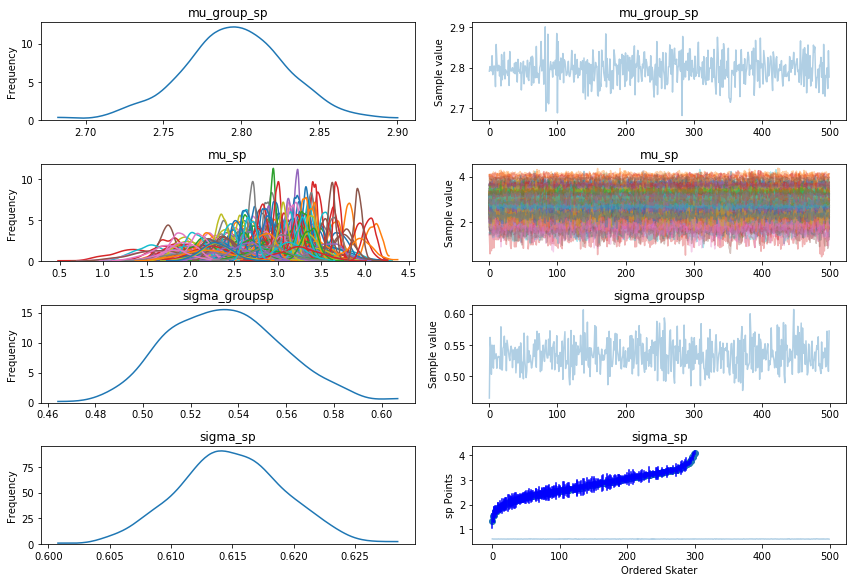

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:07<00:00, 125.07it/s]


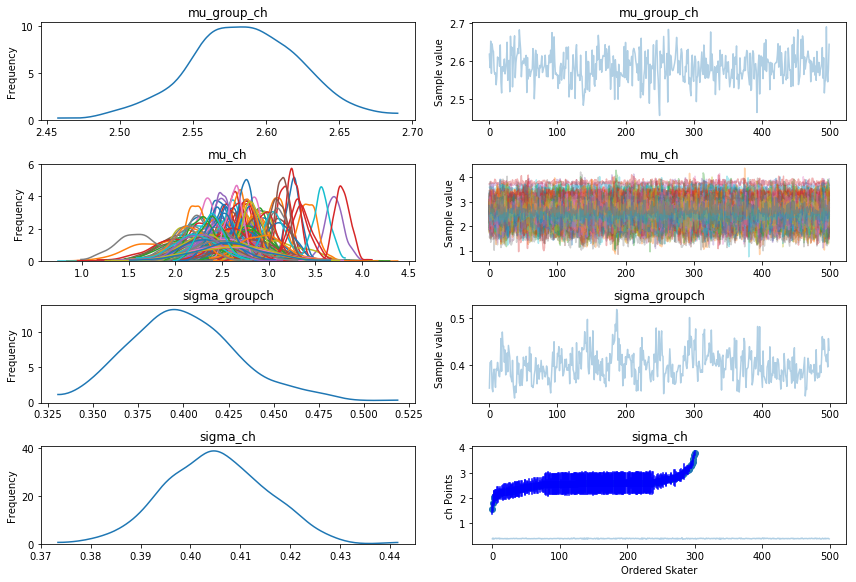

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:15<00:00, 65.70it/s]


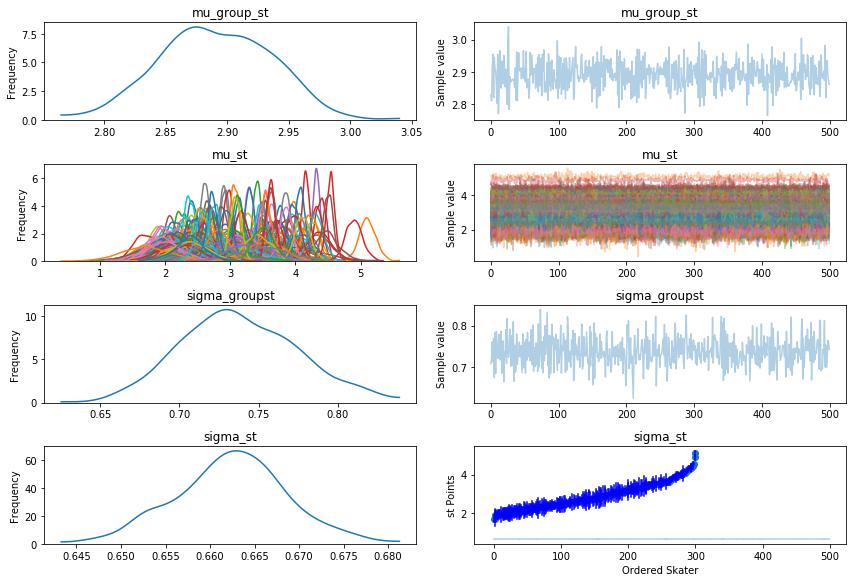

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:06<00:00, 159.63it/s]


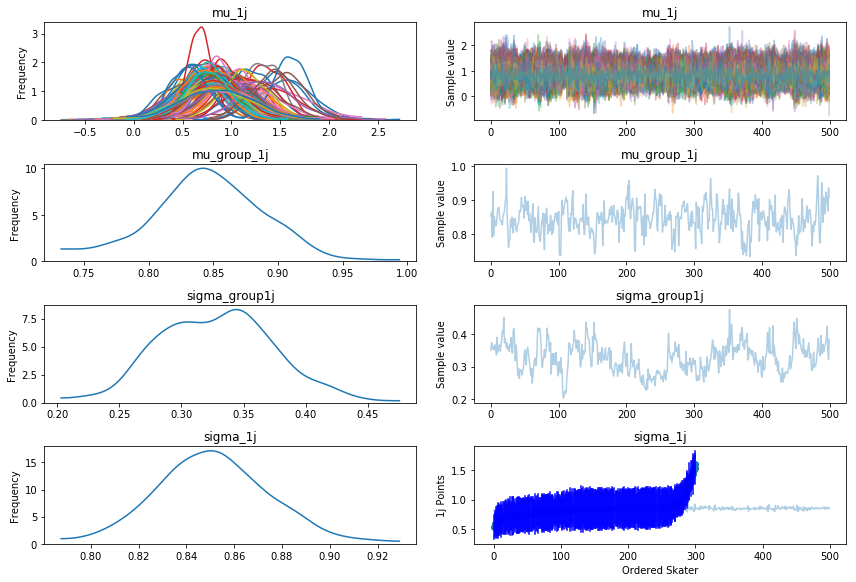

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:10<00:00, 95.64it/s]


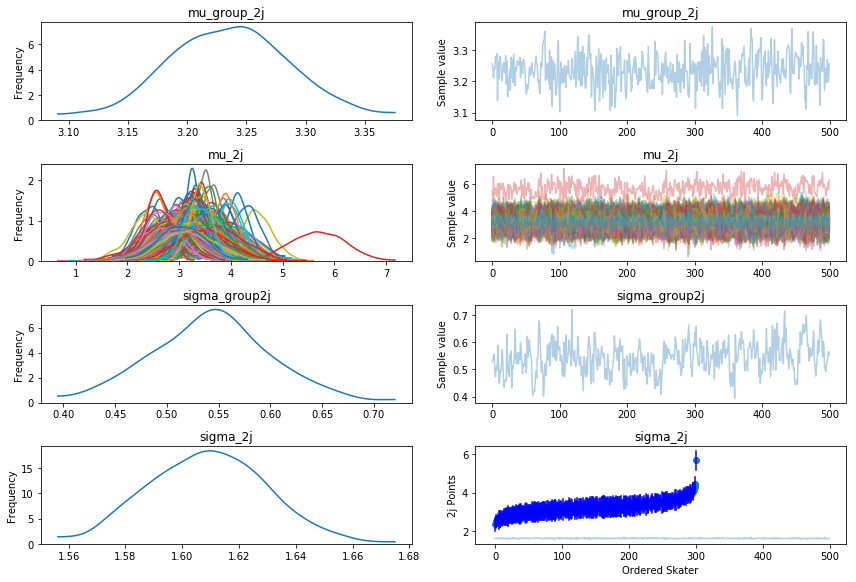

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:33<00:00, 30.00it/s]


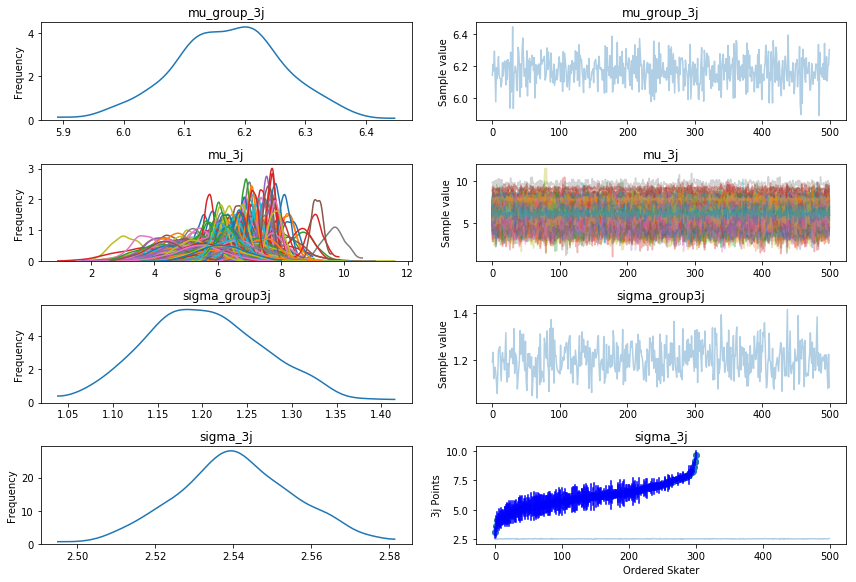

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:11<00:00, 88.93it/s]


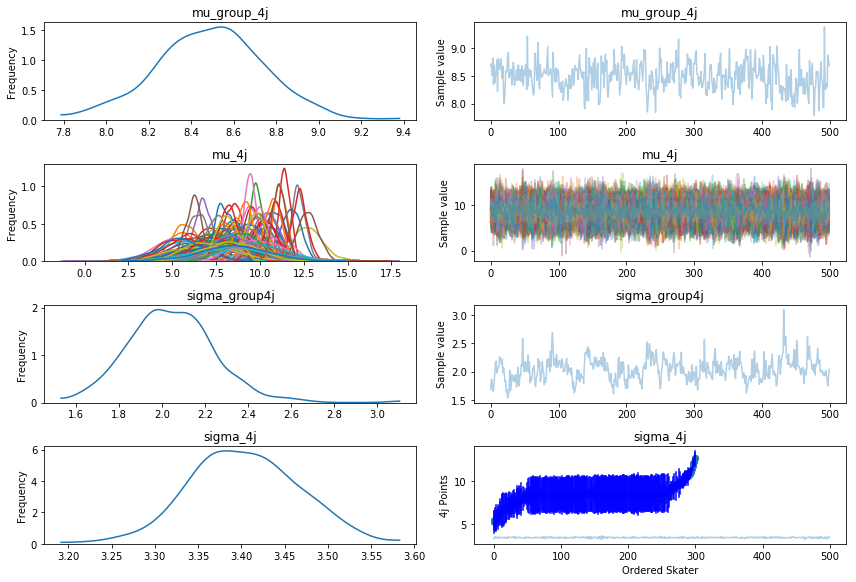

In [9]:
for elt_type, prior_mu in (('sp', 2.5), ('ch', 1.), ('st', 3.), 
                           ('1j', 1.5), ('2j', 4.), ('3j', 6.), ('4j', 10.5)):
    elts = elements[elements.elt_type == elt_type]
    skater = elts['skater_code'] = elts.skater.replace(skater_lookup).values
    skater = theano.shared(skater)
    skater_theano[elt_type] = skater
    points = elts.points
    
    partial_pooling_results[elt_type] = {}
    partial_pooling = pm.Model()

    with partial_pooling:
        if elt_type == '1j':
            mu_g = pm.Exponential('mu_group_1j', lam=prior_mu)
        else:
            mu_g = pm.Normal('mu_group_' + elt_type, prior_mu, sd=1e5)
        sigma_g = pm.HalfCauchy('sigma_group' + elt_type, 5)
        
        mu = pm.Normal('mu_' + elt_type, mu=mu_g, sd=sigma_g, shape=num_skaters)
        sigma = pm.HalfCauchy('sigma_' + elt_type, 5)
        y = pm.Normal('y_' + elt_type, mu[skater], sd=sigma, observed=points)

    with partial_pooling:
        partial_pooling_trace = pm.sample()
    partial_pooling_results[elt_type] = partial_pooling_trace
    partial_pooling_models[elt_type] = partial_pooling
    pm.traceplot(partial_pooling_trace)

    estimates = pd.Series(partial_pooling_trace['mu_' + elt_type].mean(axis=0), index=skaters)
    se = pd.Series(partial_pooling_trace['mu_' + elt_type].std(axis=0), index=skaters)

    order = estimates.sort_values().index
    plt.scatter(xrange(len(estimates)), estimates[order])
    for i, m, s in zip(range(len(estimates)), estimates[order], se[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Skater');
    plt.show()

In [13]:
partial_pooling_models['sp']

In [13]:
def plot_trace(partial_pooling_trace, elt_type):
    estimates = pd.Series(partial_pooling_trace['mu_' + elt_type].mean(axis=0), index=skaters)
    se = pd.Series(partial_pooling_trace['mu_' + elt_type].std(axis=0), index=skaters)

    order = estimates.sort_values().index
    print order[-1]
    plt.scatter(xrange(len(estimates)), estimates[order])
    for i, m, s in zip(range(len(estimates)), estimates[order], se[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Skater');

Patrick CHAN


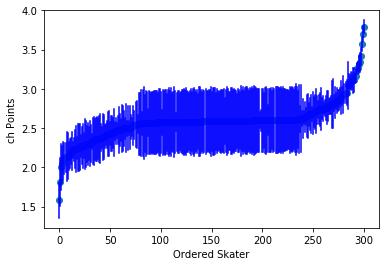

Jason BROWN


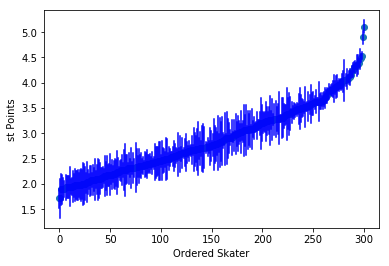

Jason BROWN


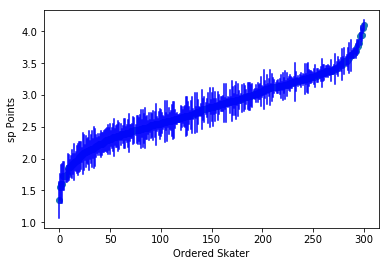

Michal BREZINA


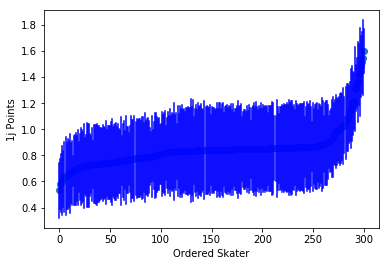

Shoma UNO


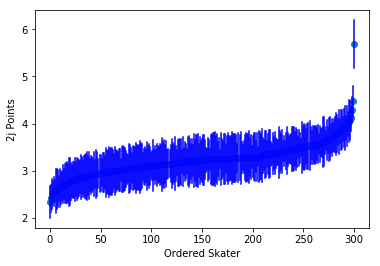

Boyang JIN


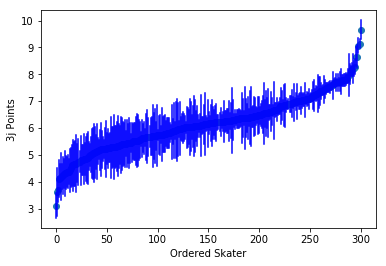

Nathan CHEN


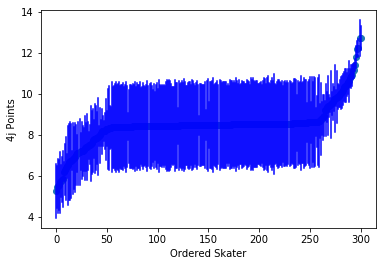

In [14]:
for elt_type in ('ch', 'st', 'sp', '1j', '2j', '3j', '4j'):
    plot_trace(partial_pooling_results[elt_type], elt_type)
    plt.show()

In [11]:
nonmulti_trace_results

{'1j': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 4 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 4 variables>},
 '2j': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>},
 '3j': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>},
 '4j': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>},
 'ch': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>},
 'sp': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>},
 'st': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace

In [ ]:
# sorted(zip(skaters, partial_pooling_results['3j']['mu_3j'].mean(axis=0)), key=lambda x: x[1])

In [172]:
ppc = {}
for elt_type in ('ch', 'st', 'sp', '1j', '2j', '3j', '4j'):
    with partial_pooling_models[elt_type]:
        skater_theano[elt_type].set_value(np.asarray(elements18[elements18.elt_type == elt_type].skater_code))
        ppc[elt_type] = pm.sample_ppc(partial_pooling_results[elt_type], model=partial_pooling_models[elt_type], samples=500)['y_' + elt_type]

100%|██████████| 500/500 [00:00<00:00, 1578.29it/s]


In [176]:
len(ppc['1j'][0])

47

In [184]:
chelts = elements18[elements18.elt_type == 'ch']

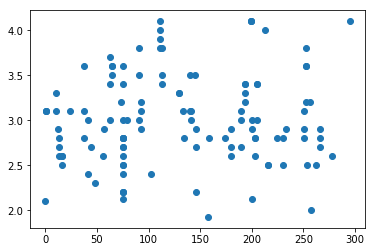

In [186]:
plt.scatter(chelts.skater_code, chelts.points)

In [19]:
ELT_TYPES = ('ch', 'st', 'sp', '1j', '2j', '3j', '4j')

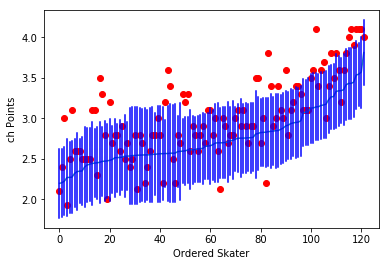

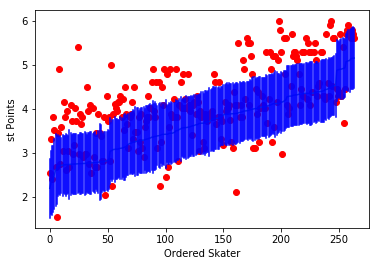

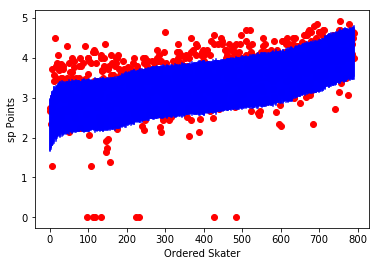

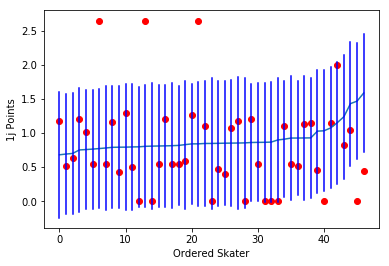

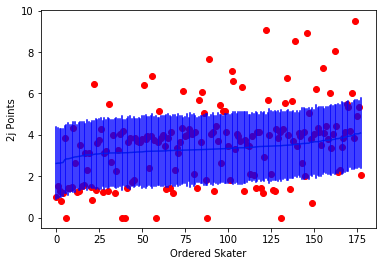

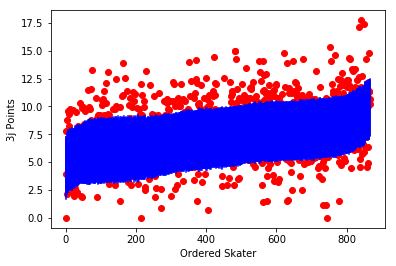

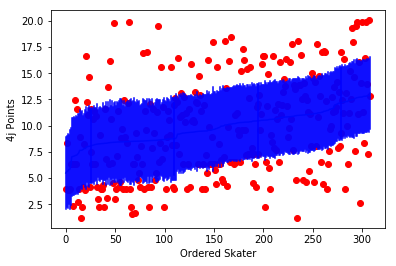

In [213]:
means = {}
for elt_type in ('ch', 'st', 'sp', '1j', '2j', '3j', '4j'):
    mean = ppc[elt_type].mean(axis=0)
    means[elt_type] = mean
    std = np.std(ppc[elt_type], axis=0)
    elt18elttype = elements18[elements18.elt_type == elt_type]
    order = pd.Series(mean).sort_values().index
    outcomes = []
    for index in order:
        outcomes.append(elt18elttype.iloc[index].points)
    plt.scatter(xrange(len(mean)), outcomes, color='r')
    plt.plot(xrange(len(mean)), [mean[x] for x in order])
    for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Skater');
    plt.show()

In [226]:
indices = {elt_type: 0 for elt_type in ELT_TYPES}
predictions_col = []
for index, row in elements18.iterrows():
    predictions_col.append(means[row.elt_type][indices[row.elt_type]])
    indices[row.elt_type] += 1

In [229]:
elements18['prediction'] = predictions_col

In [234]:
prev_skater = None
actual_tes = []
predicted_tes = []
for _, row in elements18[elements18.event == 'gprus2017'].iterrows():
    if row.skater == prev_skater:
        actual_tes[-1] += row.points
        predicted_tes[-1] += row.prediction
    else:
        actual_tes.append(row.points)
        predicted_tes.append(row.prediction)
        prev_skater = row.skater

In [245]:
zip(zip(actual_tes[12:], predicted_tes[12:]), elements18[elements18.segment == 'gprus2017 men_free'].skater.unique())

[((101.53999999999999, 92.14307821844989), 'Yuzuru HANYU'),
 ((104.85000000000002, 97.65373825599332), 'Nathan CHEN'),
 ((100.27, 93.07874384874333), 'Mikhail KOLYADA'),
 ((85.38999999999999, 68.81319640493975), 'Misha GE'),
 ((90.95, 77.67817824965869), 'Moris KVITELASHVILI'),
 ((83.43, 79.87003049643734), 'Nam NGUYEN'),
 ((73.56, 70.3640623670329), 'Dmitri ALIEV'),
 ((62.99000000000001, 68.58667759693574), 'Denis TEN'),
 ((65.28999999999999, 75.01421321252128), 'Deniss VASILJEVS'),
 ((66.11, 74.4402414909266), 'Grant HOCHSTEIN'),
 ((64.4, 64.68924035482132), 'Andrei LAZUKIN'),
 ((52.39, 61.73916590193294), 'Daniel SAMOHIN')]

In [244]:
elements18[elements18.segment == 'gprus2017 men_free'].skater.unique()

array(['Yuzuru HANYU', 'Nathan CHEN', 'Mikhail KOLYADA', 'Misha GE',
       'Moris KVITELASHVILI', 'Nam NGUYEN', 'Dmitri ALIEV', 'Denis TEN',
       'Deniss VASILJEVS', 'Grant HOCHSTEIN', 'Andrei LAZUKIN',
       'Daniel SAMOHIN'], dtype=object)

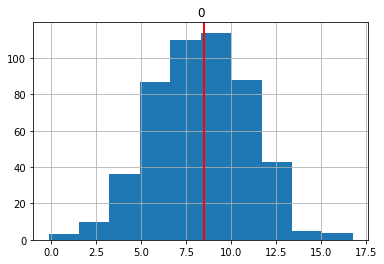

In [119]:
pd.DataFrame(fst).hist()
plt.axvline(x=8.49, color='r', linewidth=2)

In [292]:
elements18

,Unnamed: 0,bonus,date,element,elt_type,event,goe,info,number,points,segment,segment_rank,skater,start_order,skater_code,partial_pool_prediction
0,0,False,2017-10-22,4Lz+3T,4j,gprus2017,1.57,NaN,1,19.47,gprus2017 men_short,1,Nathan CHEN,10,205,12.647146
1,1,False,2017-10-22,FSSp4,sp,gprus2017,0.86,NaN,2,3.86,gprus2017 men_short,1,Nathan CHEN,10,205,3.773436
2,2,False,2017-10-22,CCSp3,sp,gprus2017,0.21,NaN,3,3.01,gprus2017 men_short,1,Nathan CHEN,10,205,3.734792
3,3,True,2017-10-22,4F,4j,gprus2017,-1.03,NaN,4,12.50,gprus2017 men_short,1,Nathan CHEN,10,205,12.459942
4,4,True,2017-10-22,3A,3j,gprus2017,-0.86,NaN,5,8.49,gprus2017 men_short,1,Nathan CHEN,10,205,8.157336
5,5,False,2017-10-22,StSq4,st,gprus2017,1.70,NaN,6,5.60,gprus2017 men_short,1,Nathan CHEN,10,205,4.524713
6,6,False,2017-10-22,CCoSp4,sp,gprus2017,1.14,NaN,7,4.64,gprus2017 men_short,1,Nathan CHEN,10,205,3.758024
7,7,False,2017-10-22,4Lo<,4j,gprus2017,-2.06,<,1,6.34,gprus2017 men_short,2,Yuzuru HANYU,12,295,11.443672
8,8,False,2017-10-22,FCSp4,sp,gprus2017,1.00,NaN,2,4.20,gprus2017 men_short,2,Yuzuru HANYU,12,295,3.907885
9,9,False,2017-10-22,CSSp4,sp,gprus2017,0.86,NaN,3,3.86,gprus2017 men_short,2,Yuzuru HANYU,12,295,3.909596


In [90]:
elements18 = pd.read_csv('pd_data/elements18_men.csv')

In [88]:
def get_idx(row):
    if row.skater not in skater_lookup:
        if row.elt_type == 'ch':
            return ch_replace
        if row.elt_type == 'st': 
            return st_replace
        if row.elt_type == 'sp':
            return sp_replace
        if row.elt_type == '1j':
            return j1_replace
        if row.elt_type == '2j':
            return j2_replace
        if row.elt_type == '3j':
            return j3_replace
        if row.elt_type == '4j':
            return j4_replace
    return skater_lookup[row.skater]

In [64]:
for skater in elements18.skater.unique():
    if skater not in skater_lookup:
        print skater

Dmitri ALIEV
Andrei LAZUKIN
Nicolas NADEAU
Jun Hwan CHA
Vincent ZHOU
He ZHANG
Kazuki TOMONO
Hiroaki SATO
Roman SADOVSKY
Irakli MAYSURADZE
Burak DEMIRBOGA
Davide LEWTON BRAIN
Yakau ZENKO
Conor STAKELUM
Donovan CARRILLO
Geon Hyeong AN
Micah Kai LYNETTE
Harrison J-Ye WONG


In [67]:
for elt_type, trace in partial_pooling_results.iteritems():
    print elt_type
    estimates = pd.Series(trace['mu_' + elt_type].mean(axis=0), index=skaters)
    order = estimates.sort_values().index
    print order[len(order)/2]

ch
Emanuel SANDHU
sp
Mark WEBSTER
st
Vaughn CHIPEUR
3j
Konrad GIERING
4j
Konstantin TUPIKOV
1j
Michael DIMALANTA
2j
Beka SHANKULASHVILI


In [70]:
ch_replace = skater_lookup['Emanuel SANDHU']
sp_replace = skater_lookup['Mark WEBSTER']
st_replace = skater_lookup['Vaughn CHIPEUR']
j3_replace = skater_lookup['Konrad GIERING']
j4_replace = skater_lookup['Konstantin TUPIKOV']
j1_replace = skater_lookup['Michael DIMALANTA']
j2_replace = skater_lookup['Beka SHANKULASHVILI']

In [91]:
elements18['skater_code'] = elements18.apply(get_idx, axis=1)

In [254]:
nonmulti_trace_results = {}
nonmulti_models = {}
nonmulti_skater_shared = {}

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:02<00:00, 674.59it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [02:10<00:00, 11.50it/s]


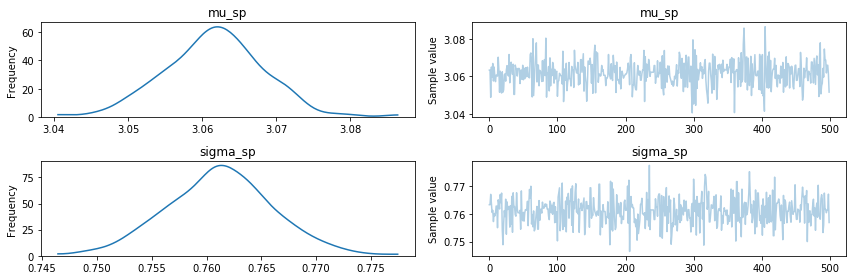

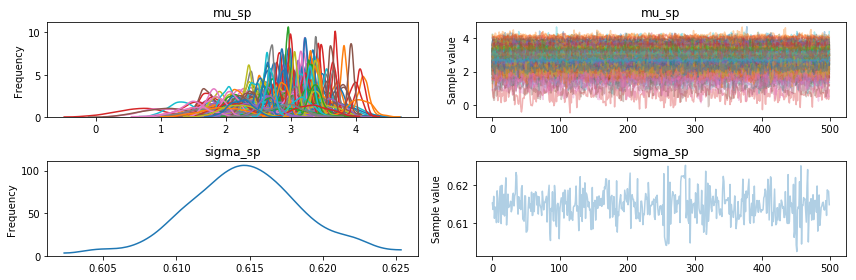

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:01<00:00, 1199.10it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:59<00:00, 25.11it/s]


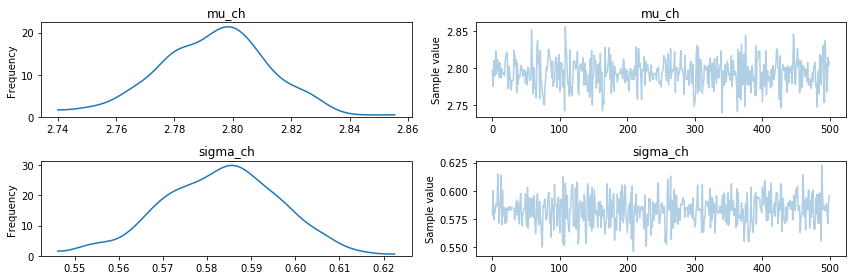

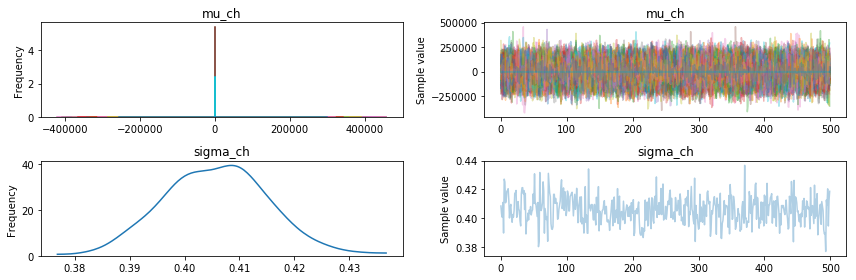

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:01<00:00, 1058.47it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:28<00:00, 52.58it/s]


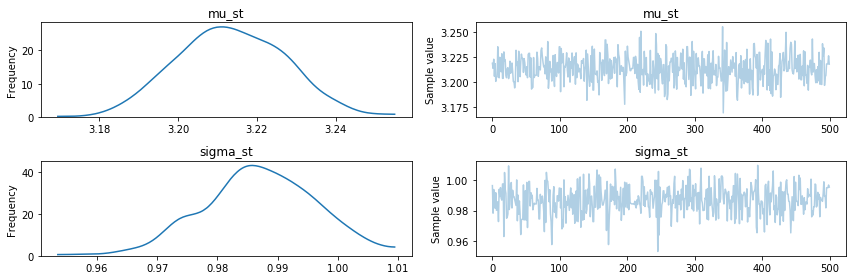

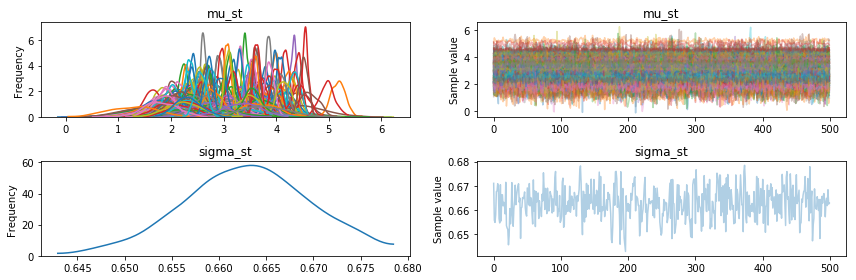

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:01<00:00, 1404.79it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:08<00:00, 184.63it/s]


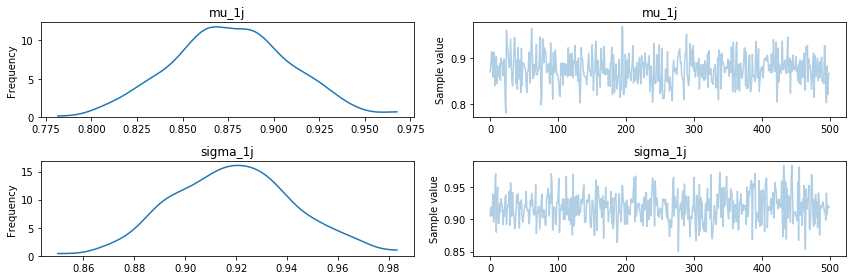

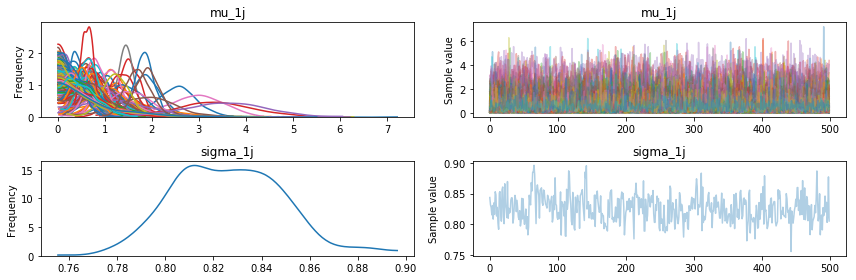

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:02<00:00, 695.46it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [01:03<00:00, 23.48it/s]


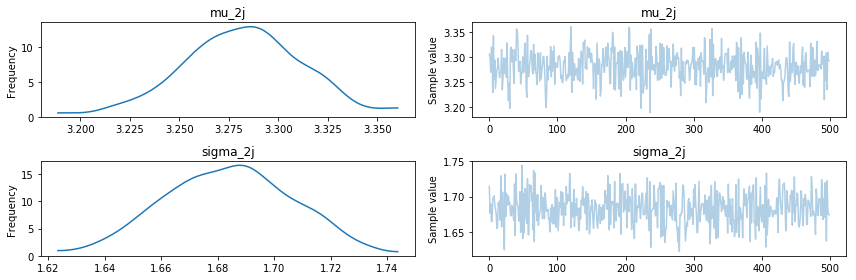

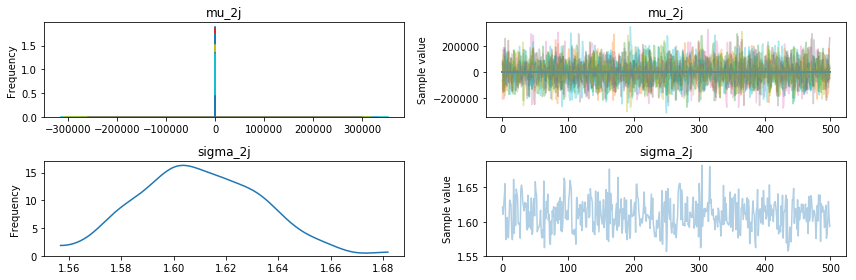

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:03<00:00, 451.32it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [01:01<00:00, 24.34it/s]


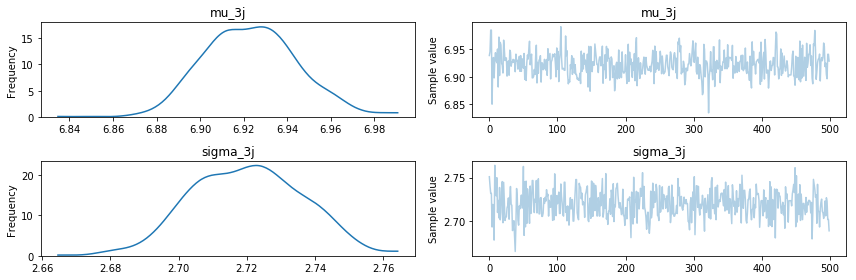

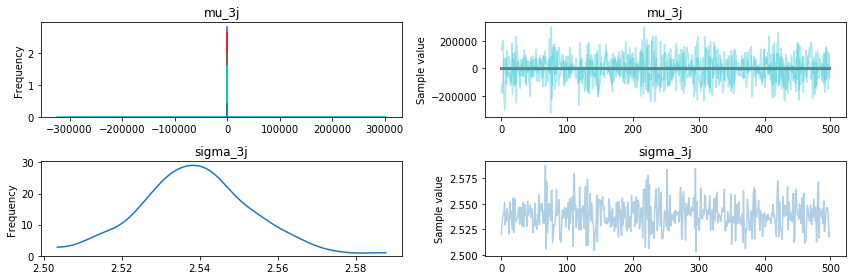

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:01<00:00, 1313.91it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:55<00:00, 27.23it/s]


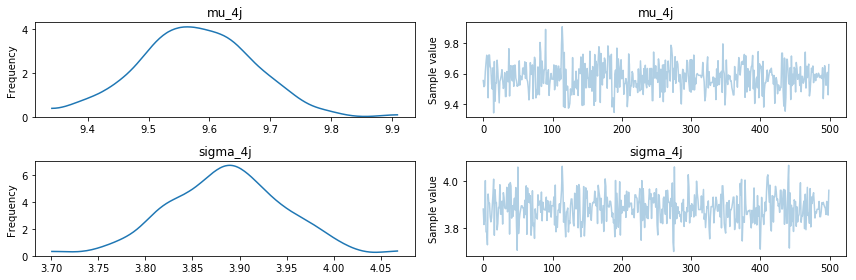

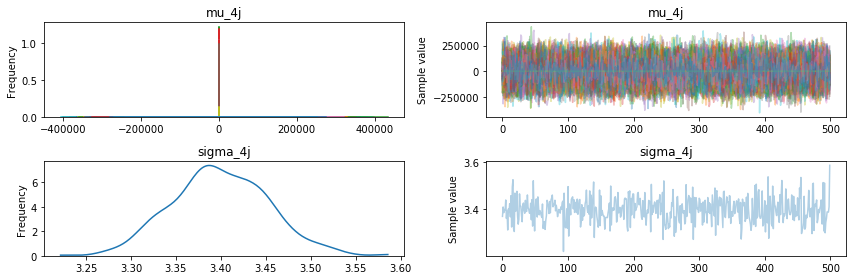

In [287]:
for elt_type, prior_mu in (('sp', 2.5), ('ch', 1.), ('st', 3.), 
                           ('1j', 1.5), ('2j', 4.), ('3j', 6.), ('4j', 10.5)):
    elts = elements[elements.elt_type == elt_type]
    skater = elts['skater_code'] = elts.skater.replace(skater_lookup).values
    skater = theano.shared(skater)
    nonmulti_skater_shared[elt_type] = skater
    points = elts.points
    
    nonmulti_trace_results[elt_type] = {}
    nonmulti_models[elt_type] = {}
    pooled_model = pm.Model()

    with pooled_model:
        if elt_type == '1j':
            mu = pm.Exponential('mu_1j', lam=prior_mu)
        else:
            mu = pm.Normal('mu_' + elt_type, prior_mu, sd=1e5)
        sigma = pm.HalfCauchy('sigma_' + elt_type, 5)
        y = pm.Normal('y_' + elt_type, mu, sd=sigma, observed=points)
        pooled_trace = pm.sample(tune=1000)

    pm.traceplot(pooled_trace)
    nonmulti_trace_results[elt_type]['pooled'] = pooled_trace
    nonmulti_models[elt_type]['pooled'] = pooled_model
    
    unpooled_model = pm.Model()

    with unpooled_model:
        if elt_type == '1j':
            mu = pm.Exponential('mu_1j', lam=prior_mu, shape=num_skaters)
        else:
            mu = pm.Normal('mu_' + elt_type, prior_mu, sd=1e5, shape=num_skaters)
        sigma = pm.HalfCauchy('sigma_' + elt_type, 5)
        y = pm.Normal('y_' + elt_type, mu[skater], sd=sigma, observed=points)
        unpooled_trace = pm.sample(tune=1000)

    pm.traceplot(unpooled_trace)
    nonmulti_trace_results[elt_type]['unpooled'] = unpooled_trace
    nonmulti_models[elt_type]['unpooled'] = unpooled_model
    plt.show()

In [4]:
with open('fits/men_nonmulti_elts.pickle') as f:
    (traces, models, skater_shared) = pickle.load(f)

In [7]:
elements_pred = pd.read_csv('fits/men_multi_elts_1.csv')

In [27]:
elements_pred.head()

,Unnamed: 0,Unnamed: 0.1,bonus,date,element,elt_type,event,goe,info,number,points,segment,segment_rank,skater,start_order,skater_code,partial_pool_prediction,pooled_prediction,unpooled_prediction
0,0,0,False,2017-10-22,4Lz+3T,4j,gprus2017,1.57,NaN,1,19.47,gprus2017 men_short,1,Nathan CHEN,10,205,12.647146,9.578746,13.102899
1,1,1,False,2017-10-22,FSSp4,sp,gprus2017,0.86,NaN,2,3.86,gprus2017 men_short,1,Nathan CHEN,10,205,3.773436,3.062927,3.787730
2,2,2,False,2017-10-22,CCSp3,sp,gprus2017,0.21,NaN,3,3.01,gprus2017 men_short,1,Nathan CHEN,10,205,3.734792,3.062927,3.787730
3,3,3,True,2017-10-22,4F,4j,gprus2017,-1.03,NaN,4,12.50,gprus2017 men_short,1,Nathan CHEN,10,205,12.459942,9.578746,13.102899
4,4,4,True,2017-10-22,3A,3j,gprus2017,-0.86,NaN,5,8.49,gprus2017 men_short,1,Nathan CHEN,10,205,8.157336,6.923761,8.681645


In [22]:
unpooled_estimates = {
    elt_type: pd.Series(traces[elt_type]['unpooled_trace']['mu_' + elt_type].mean(axis=0), index=skaters)
    for elt_type in ELT_TYPES
}
unpooled_medians = {elt_type: np.median(unpooled_estimates[elt_type]) for elt_type in ELT_TYPES}

In [11]:
elements_pred['pooled_prediction'] = elements_pred.apply(lambda row: traces[row.elt_type]['pooled_trace']['mu_' + row.elt_type].mean(axis=0), axis=1)

In [26]:
elements_pred['unpooled_prediction'] = elements_pred.apply(
    lambda row: unpooled_medians[row.elt_type] if row.skater not in skater_lookup else unpooled_estimates[row.elt_type].ix[row.skater],
    axis=1
)

In [28]:
elements_pred.to_csv('fits/men_multi_elts_1.csv')

In [261]:
nonmulti_traces

{'1j': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 4 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 4 variables>},
 '2j': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>},
 '3j': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>},
 '4j': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>},
 'ch': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>},
 'sp': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>},
 'st': {'pooled_trace': <MultiTrace: 1 chains, 500 iterations, 3 variables>,
  'unpooled_trace

In [279]:
# Make predictions.
ppc_pooled = {}
ppc_unpooled = {}
for elt_type in ('ch', 'st', 'sp', '2j', '3j', '4j'):
    print elt_type
    with nonmulti_models[elt_type]['pooled']:
        ppc_pooled[elt_type] = pm.sample_ppc(nonmulti_traces[elt_type]['pooled_trace'])['y_' + elt_type]
    with nonmulti_models[elt_type]['unpooled']:
        nonmulti_skater_shared[elt_type].set_value(
            np.asarray(elements18[elements18.elt_type == elt_type].skater_code))
        ppc_unpooled[elt_type] = pm.sample_ppc(nonmulti_traces[elt_type]['unpooled_trace'])['y_' + elt_type]

 26%|██▌       | 131/500 [00:00<00:00, 1307.57it/s]

ch


 21%|██        | 105/500 [00:00<00:00, 1048.70it/s]

st


 38%|███▊      | 191/500 [00:00<00:00, 1902.35it/s]

sp


  0%|          | 1/500 [00:00<00:50,  9.81it/s]

2j


  6%|▋         | 32/500 [00:00<00:01, 319.29it/s]

3j


 14%|█▍        | 72/500 [00:00<00:00, 707.12it/s]

4j


100%|██████████| 500/500 [00:07<00:00, 64.01it/s]


In [266]:
ppc_unpooled.keys()

['ch', 'sp', 'st']

In [286]:
ppc_pooled['ch']

array([  5.24914902e+04,   2.17139730e+04,   6.33713139e+04,
         3.49453485e+04,   9.99272092e+04,   3.85294654e+04,
         1.02883090e+05,   8.31013718e+04,   5.11099991e+04,
         1.07648137e+05,  -1.74071633e+05,  -1.86001343e+04,
         2.27910231e+05,   6.95166227e+04,   8.61331657e+03,
        -2.65893600e+05,   6.97518493e+04,   2.90397553e+04,
        -1.00851252e+05,   1.13836003e+05,   1.54027989e+05,
        -1.56504303e+05,  -2.13972899e+05,  -1.70340673e+04,
        -1.37927449e+05,  -1.62689078e+04,  -1.90149459e+04,
        -4.66004325e+03,  -1.29719791e+05,  -4.93687711e+04,
         1.65793766e+04,   1.10940402e+05,  -5.21789458e+04,
         2.74867897e+04,   5.65404910e+04,  -2.07548894e+04,
         7.92055121e+04,   6.38970017e+04,   1.09850821e+05,
         8.48438996e+03,  -6.16830542e+04,   2.69951734e+05,
        -3.87833953e+04,   6.02492237e+04,   5.71204241e+03,
        -7.41770330e+04,   1.35085355e+05,  -6.45114268e+04,
        -2.43007611e+04,

In [280]:
means = {}
for elt_type in ('ch', 'st', 'sp', '2j', '3j', '4j'):
    mean = ppc_pooled[elt_type].mean(axis=0)
    means[elt_type] = mean
    std = np.std(ppc_pooled[elt_type], axis=0)
    elt18elttype = elements18[elements18.elt_type == elt_type]
    order = pd.Series(mean).sort_values().index
    outcomes = []
    for index in order:
        outcomes.append(elt18elttype.iloc[index].points)
    plt.scatter(xrange(len(mean)), outcomes, color='r')
    plt.plot(xrange(len(mean)), [mean[x] for x in order])
    for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Skater');
    plt.show()

TypeError: object of type 'numpy.float64' has no len()

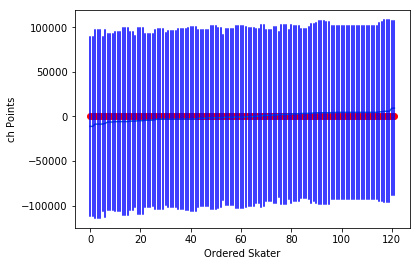

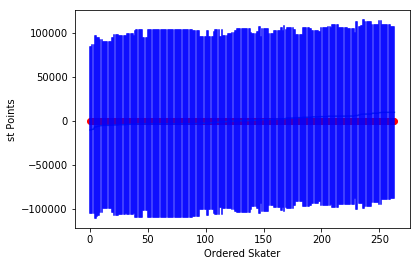

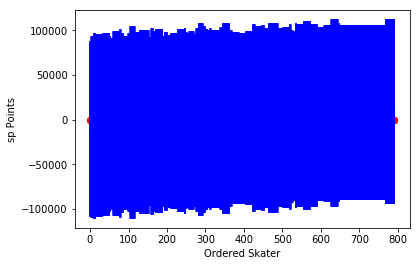

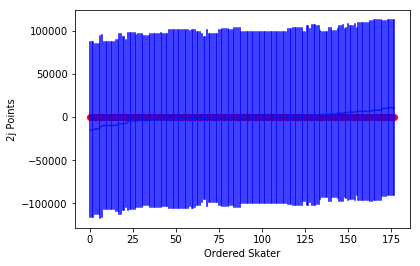

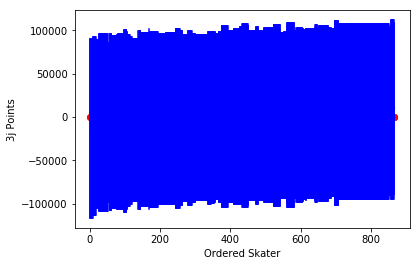

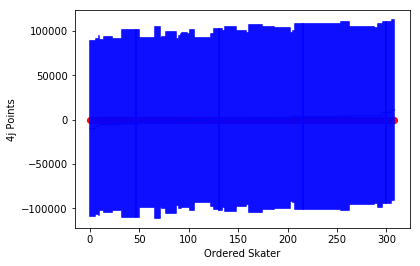

In [288]:
means = {}
for elt_type in ('ch', 'st', 'sp', '2j', '3j', '4j'):
    mean = ppc_unpooled[elt_type].mean(axis=0)
    means[elt_type] = mean
    std = np.std(ppc_unpooled[elt_type], axis=0)
    elt18elttype = elements18[elements18.elt_type == elt_type]
    order = pd.Series(mean).sort_values().index
    outcomes = []
    for index in order:
        outcomes.append(elt18elttype.iloc[index].points)
    plt.scatter(xrange(len(mean)), outcomes, color='r')
    plt.plot(xrange(len(mean)), [mean[x] for x in order])
    for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Skater');
    plt.show()

In [293]:
elements18.to_csv('fits/men_multi_elts_1.csv')